# IBM Dynamical Decoupling Optimizations with Superstaq

<a target="_blank" href="https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_dd.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/>
</a>
<a target="_blank" href="https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_dd.ipynb">
  <img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder" align="left" style="margin-left: 10px;"/>
</a>

[Dynamical decoupling (DD)](https://arxiv.org/abs/quant-ph/9803057) is an error mitigation technique used to suppress noise added to computation from system-environment interaction (i.e. decoherence error). DD is implemented during algorithm execution by adding special gate sequences that are equal to the identity operation in periods of qubit idling. Examples of DD sequences include XX, XY4, XY8, and UDD, among others.

Below is a brief tutorial on Superstaq dynamical decoupling optimizations for the IBM family of superconducting quantum devices. In the example, a CPMG sequence, XX, will be used. 

Many [research articles](https://arxiv.org/abs/2207.03670) can be found that describe the variations and benefits of DD. For more information about IBM Quantum, visit their website [here](https://quantum-computing.ibm.com/).


In [1]:
%pip install qiskit-superstaq

In [1]:
# Required imports
import numpy as np
import qiskit
import qiskit_superstaq as qss

# Optional imports
import os  # used if setting a token as an environment variable

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://docs-superstaq.readthedocs.io/en/stable/get_started/basics/basics_qss.html#Import-Superstaq-and-requirements)).

In [2]:
# Get the qiskit superstaq provider for Superstaq backend
# Provide your api key to the using the "api_key" argument if
# SUPERSTAQ_API_KEY environment variable is not set.
provider = qss.SuperstaqProvider()

In [3]:
lagos_backend = provider.get_backend("ibmq_lagos_qpu")

In [4]:
qc = qiskit.QuantumCircuit(4)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.measure_all()
qc.draw()

┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3

In [5]:
qc_compiled = lagos_backend.compile(qc)

In [8]:
qc_compiled.circuit.draw(fold=-1)

q_0: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ┌─────────┐                                           ┌─────────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────────┐┌─────────┐┌─────────┐             ░ ┌─┐         
q_1: ┤ Rx(π/2) ├───────────────────────────────────────────┤1            ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤1            ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────────────░─┤M├─────────
     ├─────────┤ ┌─────────┐                               │             │└─────────┘└─────────┘└─────────┘│  Acecr(π/2) │├─────────┤├─────────┤┌──────────┐ ░ └╥┘┌─┐      
q_2: ┤ Rz(π/2) ├─┤ Rx(π/2) ├───────────────────────────────┤  Acecr(π/2) ├─────────────────────────────────┤0            ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(3π/2) ├─░──╫─┤M├──────
     ├─────────┤ └─────────┘┌─────────────┐┌─────────┐┌───┐│             │                                 └─────────────┘└─────────┘└─────────┘└──────────┘ ░  ║ └╥┘┌─┐   
q_3: ┤ Rx(π/2) ├────────────┤1            ├┤ Rz(π/2) ├┤ X ├┤0            ├───────────────────────────────────────────────────────────────────────────────────░──╫──╫─┤M├───
     └─────────┘            │             │└─────────┘└───┘└─────────────┘                                                                                   ░  ║  ║ └╥┘   
q_4: ───────────────────────┤  Acecr(π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──╫──╫────
     ┌──────────┐┌─────────┐│             │                                                                                                                  ░  ║  ║  ║ ┌─┐
q_5: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤0            ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫──╫──╫─┤M├
     └──────────┘└─────────┘└─────────────┘                                                                                                                  ░  ║  ║  ║ └╥┘
q_6: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──╫──╫──╫─
                                                                                                                                                                ║  ║  ║  ║ 
c: 4/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                2  3  1  0

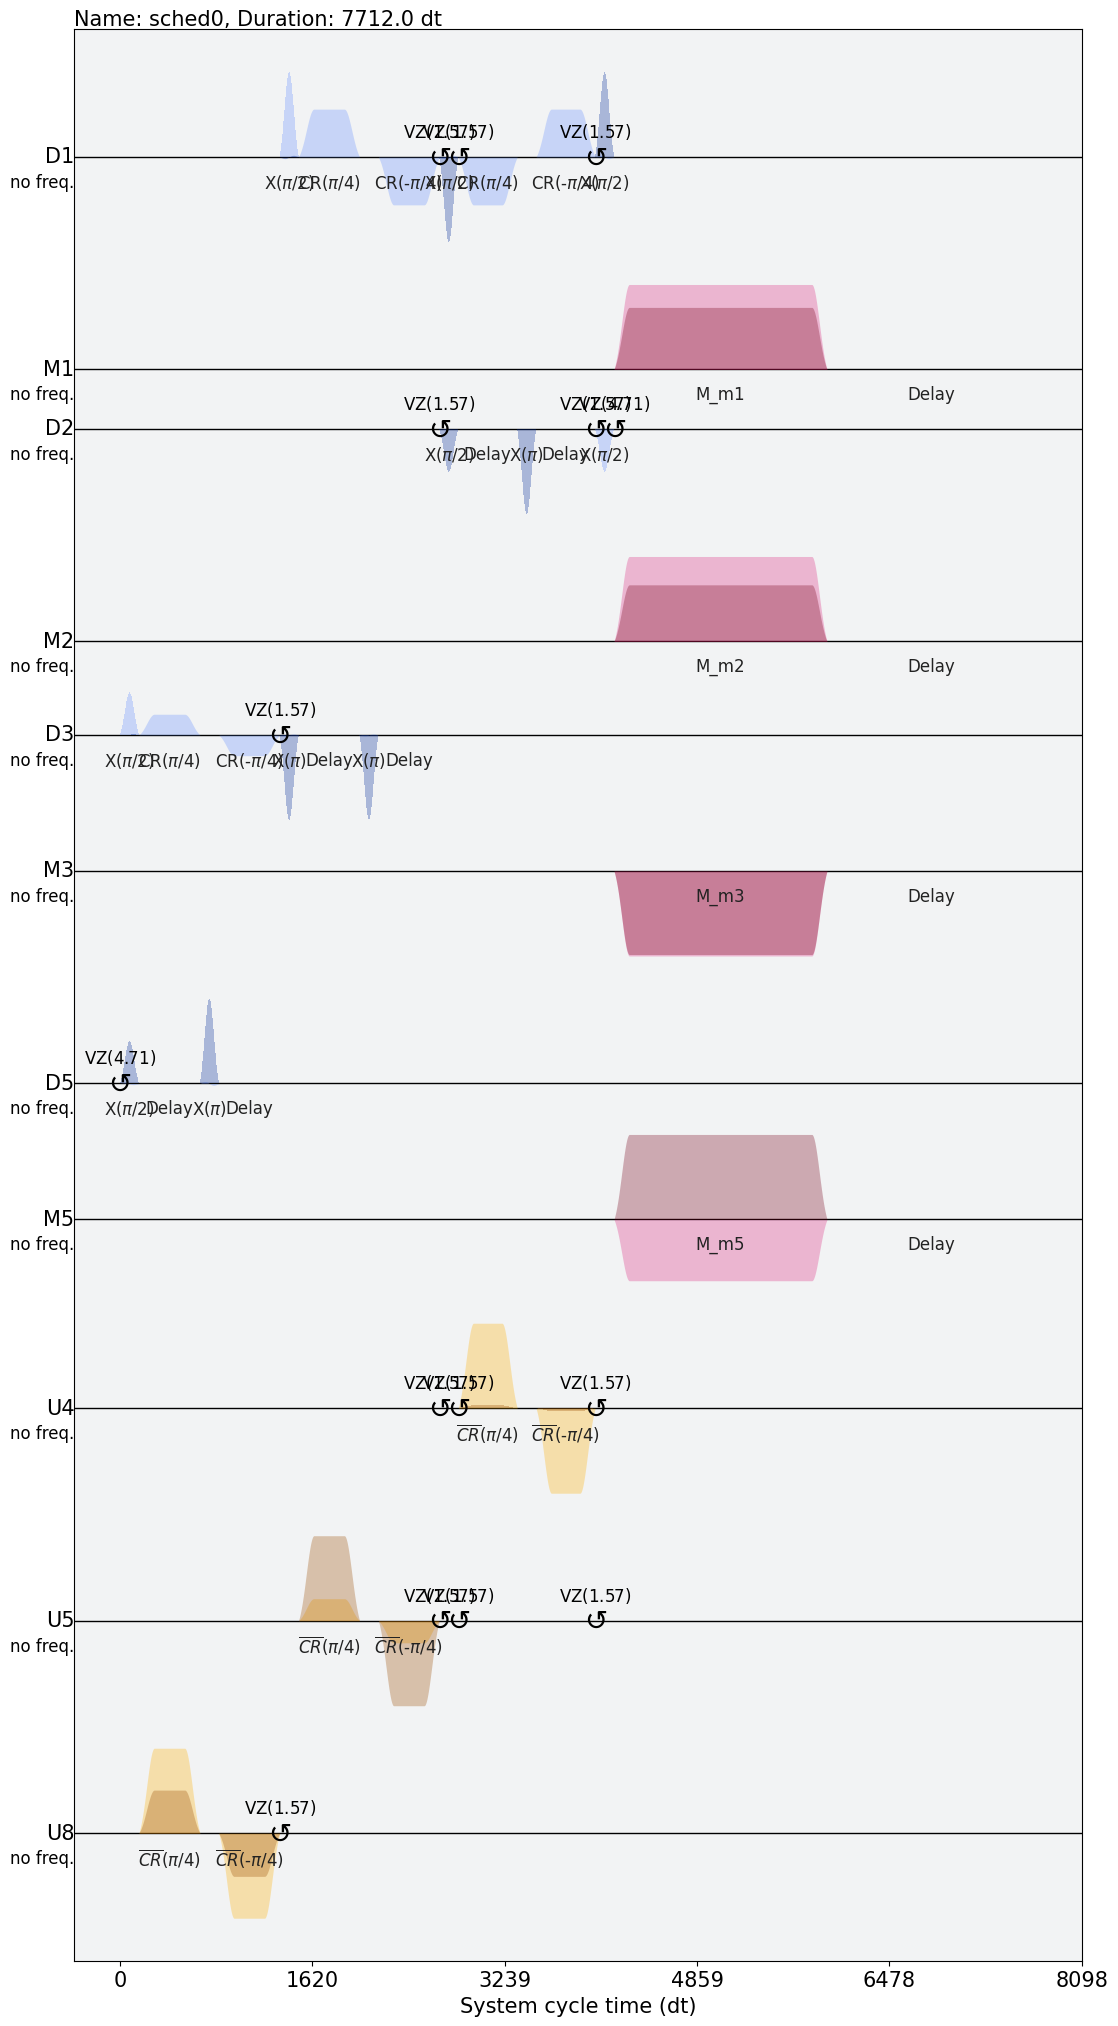

In [10]:
qc_compiled.pulse_sequence.draw()

In [9]:
qc_compiled_dd = lagos_backend.compile(qc, dynamical_decoupling=True)

In [11]:
qc_compiled_dd.circuit.draw(fold=-1)

q_0: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ┌─────────┐                                           ┌─────────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────────┐┌─────────┐┌─────────┐                                           ░ ┌─┐         
q_1: ┤ Rx(π/2) ├───────────────────────────────────────────┤1            ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤1            ├┤ Rz(π/2) ├┤ Rx(π/2) ├───────────────────────────────────────────░─┤M├─────────
     ├─────────┤ ┌─────────┐                               │             │└─────────┘└─────────┘└─────────┘│  Acecr(π/2) │├─────────┤├─────────┤┌──────────┐                               ░ └╥┘┌─┐      
q_2: ┤ Rz(π/2) ├─┤ Rx(π/2) ├───────────────────────────────┤  Acecr(π/2) ├─────────────────────────────────┤0            ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(3π/2) ├───────────────────────────────░──╫─┤M├──────
     ├─────────┤ └─────────┘┌─────────────┐┌─────────┐┌───┐│             │   ┌───┐      ┌───┐      ┌───┐   └────┬───┬────┘└──┬───┬──┘└──┬───┬──┘└──┬───┬───┘┌───┐                          ░  ║ └╥┘┌─┐   
q_3: ┤ Rx(π/2) ├────────────┤1            ├┤ Rz(π/2) ├┤ X ├┤0            ├───┤ X ├──────┤ X ├──────┤ X ├────────┤ X ├────────┤ X ├──────┤ X ├──────┤ X ├────┤ X ├──────────────────────────░──╫──╫─┤M├───
     └─────────┘            │             │└─────────┘└───┘└─────────────┘   └───┘      └───┘      └───┘        └───┘        └───┘      └───┘      └───┘    └───┘                          ░  ║  ║ └╥┘   
q_4: ───────────────────────┤  Acecr(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──╫──╫────
     ┌──────────┐┌─────────┐│             │   ┌───┐   ┌───┐     ┌───┐        ┌───┐      ┌───┐      ┌───┐        ┌───┐        ┌───┐      ┌───┐      ┌───┐    ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐ ░  ║  ║  ║ ┌─┐
q_5: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤0            ├───┤ X ├───┤ X ├─────┤ X ├────────┤ X ├──────┤ X ├──────┤ X ├────────┤ X ├────────┤ X ├──────┤ X ├──────┤ X ├────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░──╫──╫──╫─┤M├
     └──────────┘└─────────┘└─────────────┘   └───┘   └───┘     └───┘        └───┘      └───┘      └───┘        └───┘        └───┘      └───┘      └───┘    └───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║  ║ └╥┘
q_6: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──╫──╫──╫─
                                                                                                                                                                                              ║  ║  ║  ║ 
c: 4/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                                              2  3  1  0

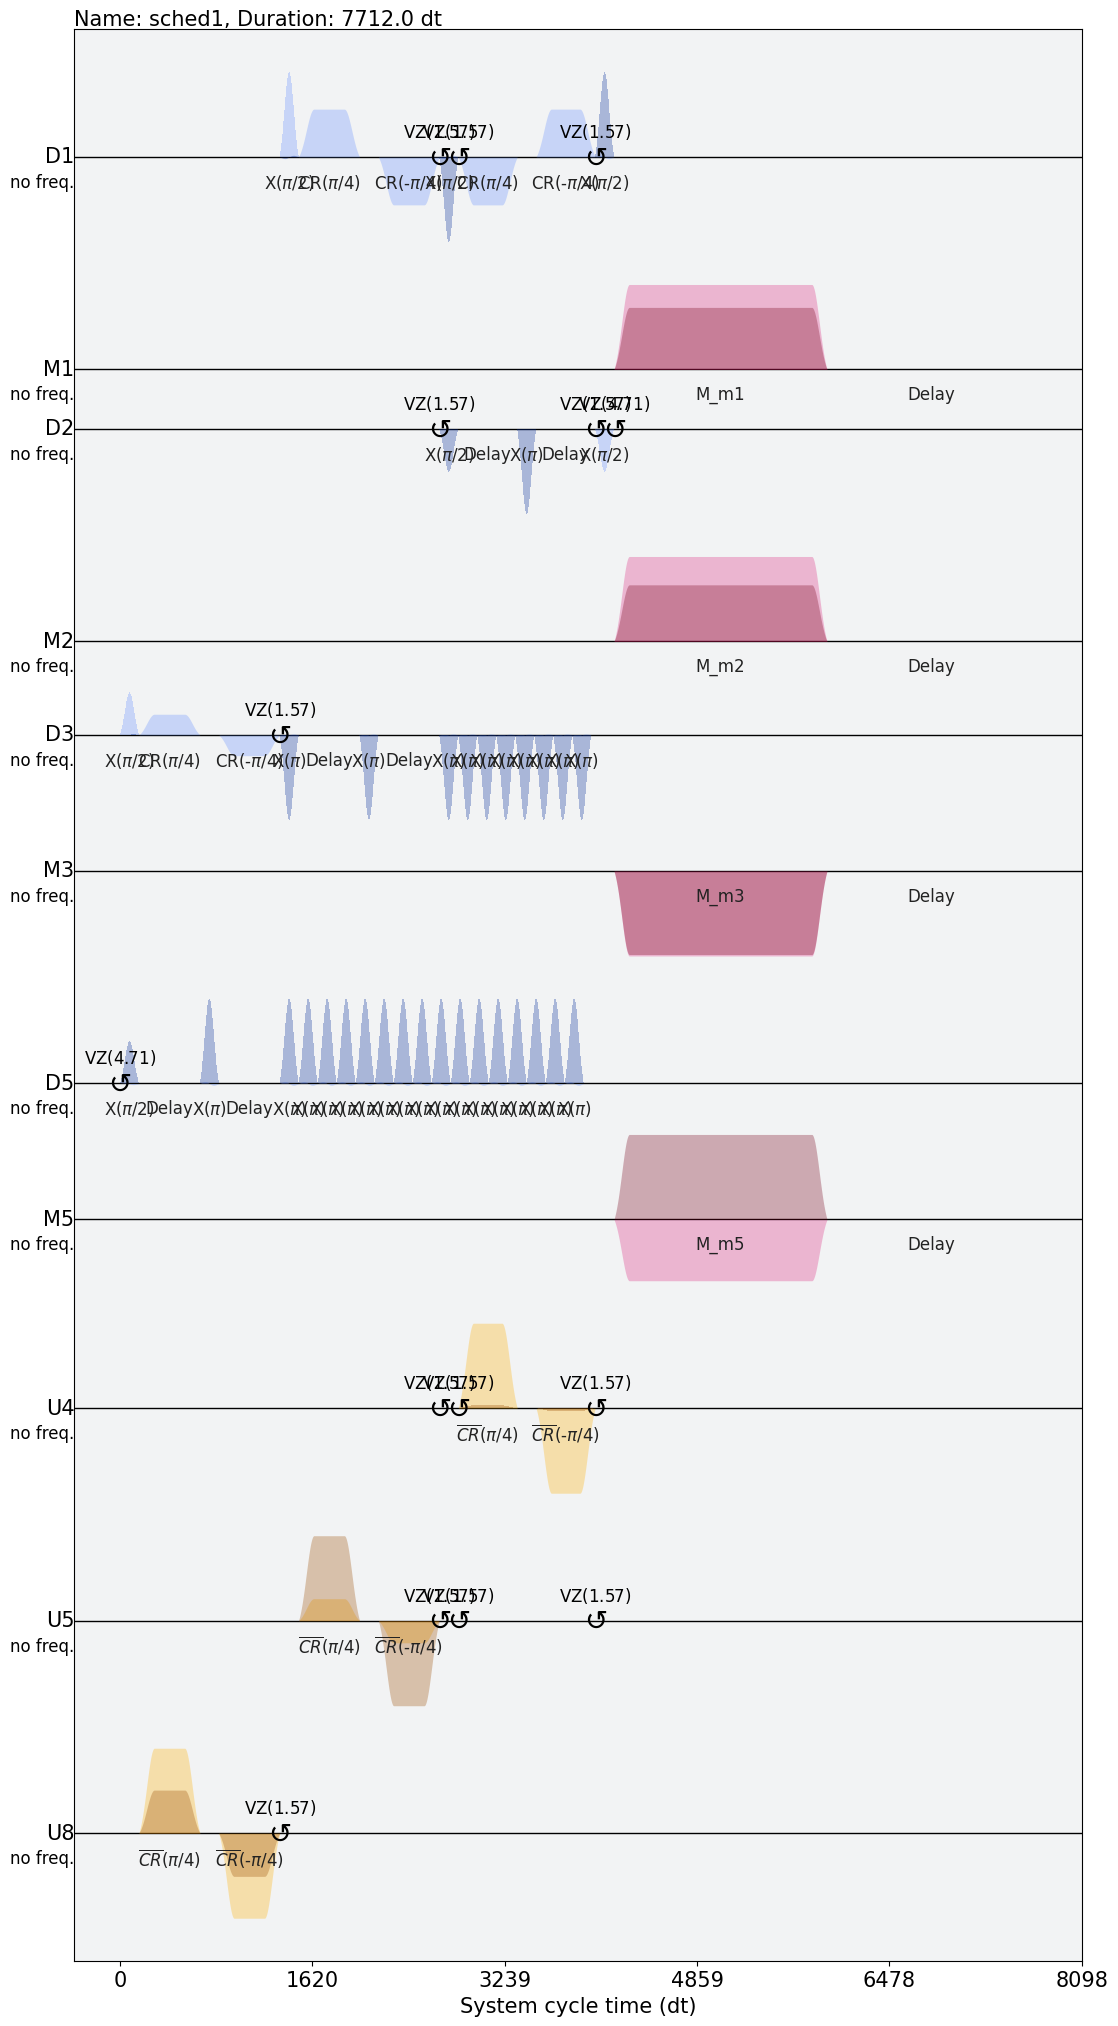

In [12]:
qc_compiled_dd.pulse_sequence.draw()